### CIFAR Dataset

In [1]:
DATA_DIR = '/home/jackalhan/Development/github/more_meaningful_representations/squad/sandbox_notebooks/tf/cifar-10-batches-py'

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fi:
        cifar_dict = pickle.load(fi, encoding='bytes')
    return cifar_dict

In [13]:
import os
ALL_DATA = {}
for root, dirs, files in os.walk(DATA_DIR, topdown=False):
    for name in files:
        print(name)
        ALL_DATA[name] = unpickle(os.path.join(root, name))

data_batch_1
batches.meta
data_batch_5
data_batch_3
data_batch_4
test_batch
data_batch_2


In [17]:
ALL_DATA['batches.meta']

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

### data : 10000x3072 nump arrays of uint8s. Each row of the array stores a 32 x 32 colour image.  3072 is coming from 1024 (32 x 32) x 3 (RGB = Channels) so First 1024 of 3072 belongs to Red, Second 1024 of 3072 belongs to Green and Last 1024 of 3072 belongs to Blue

### label: a list of 10000 umbers in the range 0-9 The number at index i indicates the label of the ith image in the array data. 

### label names: batches.meta.label_names, a 10-element list which gives meaning-ful names to the numeric labels in the labels array described above. For example : label_names[0] == 'airplane', label_names[1] == 'automobile'

In [19]:
ALL_DATA['data_batch_1'].keys()

dict_keys([b'labels', b'batch_label', b'filenames', b'data'])

In [123]:
X = ALL_DATA['data_batch_1'][b"data"]

In [124]:
X.shape

(10000, 3072)

In [125]:
X = X.reshape(X.shape[0], 3,32,32)

In [126]:
sample_x = X[12]

In [127]:
sample_x.shape

(3, 32, 32)

(32, 32, 3)


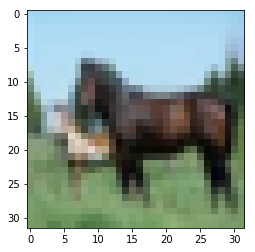

In [128]:
# Shape (3, 32, 32) does not work with plt.imshow()
# therefore we need to convert it to (32,32,3)
sample_x = sample_x.transpose(1,2,0)
print(sample_x.shape)
plt.imshow(sample_x)

In [129]:
#In order to change the shape of all the images in X :
# we have 2 options, 
## 1 is :
X =X.transpose(0,2,3,1).astype("uint8") #Uint8 efficient loading.
## 2 is :
## X = X.swapaxes(2,3).swapaxes(1,3)

In [121]:
X.shape

(10000, 32, 32, 3)

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

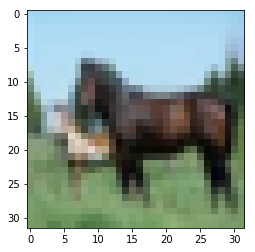

In [130]:
plt.imshow(X[12])

### Helper Functions

In [183]:
def one_hot_encode(vec, encode_size=10):
    n = len(vec)
    out = np.zeros((n, encode_size))
    # set the value 1 to the index associated with label of the vector
    out[range(n), vec] = 1
    return out

In [224]:
class CifarHelper():
    
    def __init__(self, ALL_DATA):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [ALL_DATA['data_batch_1'], 
                                  ALL_DATA['data_batch_2'], 
                                  ALL_DATA['data_batch_3'], 
                                  ALL_DATA['data_batch_4'], 
                                  ALL_DATA['data_batch_5']]
        
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [ALL_DATA['test_batch']]
        
        # Initialize some empty variables for later on
        self.training_images= None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print('Setting up Training Images and Labels')
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        # Reshapes and normalize training images by max rgb value
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1) / 255
        # One hot encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0,])
        self.training_labels = one_hot_encode(np.hstack(
            [d[b"labels"] for d in self.all_train_batches]
        ))
        
        print("Setting Up Test Images and Labels")
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalized test images
        self.test_images = self.test_images.reshape(test_len, 3,32,32).transpose(0,2,3,1)
        # One hot encodes
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]))
    
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i + batch_size].reshape(batch_size, 32,32,3)
        y = self.training_labels[self.i:self.i + batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [225]:
ch = CifarHelper(ALL_DATA)
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.traing.next_batch)
# Batch = ch.next_batch(100)

Setting up Training Images and Labels
Setting Up Test Images and Labels


#### Helper Functions

In [199]:
# INIT WEIGHTS
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

# INIT BIAS
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

# CONV2D
def conv2d(x, W):
    # x --> input tensor, so shape:[batch, H, W, Channels]
    # W --> kernel, shape:[filter_height, filter_width, channels_in, channels_out]    
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding='SAME') # SAME = zero padding

# POOLING
def max_pooling_2by2(x):
    # x --> input tensor, so shape:[batch, H, W, Channels]
    # ksize, strides --> we want to apply pooling to the H and W values of the tensor (image) 
    # therefore we need to skip the
    # batch and channels by putting 1, and the rest is 2
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME') # SAME = zero padding

# CONVOLUTIONAL LAYER
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    _conv2d = conv2d(input_x, W) + b
    return tf.nn.relu(_conv2d)

# FULLY CONNECTED LAYER
def fully_connected_layer(input_layer, size):
    #size = neuron size in fully connected layer
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    _fully_connected_layer = tf.matmul(input_layer, W) + b
    return _fully_connected_layer

### Creating the Model

In [203]:
import tensorflow as tf

In [204]:
X = tf.placeholder(tf.float32, shape=[None, 32,32,3])
y = tf.placeholder(tf.uint8, shape=[None, 10])
hold_prob_dropout = tf.placeholder(tf.float32)

#### Create the Layers

In [205]:
convo_1 = convolutional_layer(X, shape=[4,4,3,32]) # 4,4 filter size, 3: input channels RGB, 32 is for output channels
convo_1_pooling = max_pooling_2by2(convo_1)

convo_2 = convolutional_layer(convo_1_pooling, shape=[4,4,32,64]) # 4,4 filter size, 3: input channels RGB, 32 is for output channels
convo_2_pooling = max_pooling_2by2(convo_2)

#### Flattened Layer

In [206]:
# reshaping the pooling layer by [-1, 4096] or [8*8*64] or what ever we want :) 
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 4096])

#### Fully Connected Layer

In [207]:
full_layer_one =tf.nn.relu(fully_connected_layer(convo_2_flat,1024))

#### Dropout Layer

In [208]:
full_one_dropout = tf.nn.dropout(full_layer_one, hold_prob_dropout)

#### Predictions

In [209]:
y_pred = fully_connected_layer(full_one_dropout, 10) #10 possible labels

### Loss Function

In [210]:
cross_entrtropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))

### Optimizer

In [211]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
# minimize our loss
train = optimizer.minimize(cross_entrtropy)

In [212]:
init = tf.global_variables_initializer()

### Graph Session

In [226]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(5000):
        batch = ch.next_batch(100)
        # x = batch[0]
        # y = batch[1]
        sess.run(train, feed_dict ={X:batch[0], y: batch[1], hold_prob_dropout: 0.5})
        if i % 100 == 0:
            print("Step: {}".format(i))
            matches = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            print(sess.run(acc, feed_dict={X:ch.test_images, y:ch.test_labels, hold_prob_dropout:1}))
            print(10*'-')

Step: 0
0.1009
----------
Step: 100
0.3487
----------
Step: 200
0.3969
----------
Step: 300
0.4019
----------
Step: 400
0.4164
----------
Step: 500
0.4227
----------
Step: 600
0.4548
----------
Step: 700
0.4334
----------
Step: 800
0.4552
----------
Step: 900
0.4569
----------
Step: 1000
0.4585
----------
Step: 1100
0.5076
----------
Step: 1200
0.4906
----------
Step: 1300
0.4969
----------
Step: 1400
0.4861
----------
Step: 1500
0.4973
----------
Step: 1600
0.5535
----------
Step: 1700
0.5452
----------
Step: 1800
0.5265
----------
Step: 1900
0.5226
----------
Step: 2000
0.531
----------
Step: 2100
0.5701
----------
Step: 2200
0.5566
----------
Step: 2300
0.5422
----------
Step: 2400
0.5518
----------
Step: 2500
0.5578
----------
Step: 2600
0.5805
----------
Step: 2700
0.5765
----------
Step: 2800
0.5586
----------
Step: 2900
0.5748
----------
Step: 3000
0.586
----------
Step: 3100
0.6017
----------
Step: 3200
0.5892
----------
Step: 3300
0.5654
----------
Step: 3400
0.5777
----------